# Data Quality Assessment

This notebook explores the routines available in `dqatool` for data quality assessment of the example Measurement Set provided.

### Loading data

In [2]:
from dqatool import rfi, plotting, imtools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

I begin by loading the data from the example MS provided and plotting the amplitudes of the different correlation products against time and frequency. To avoid overwhelming the jupyter notebook by rendering millions of points, previously saved plots are displayed here. The plotting routines used can be found in `dqatool.plotting`.

In [3]:
ms_path = "/home/memer/projects/skao_sdp_engineer/assignment/dqatool/examples/pipeline_problem_data.ms"

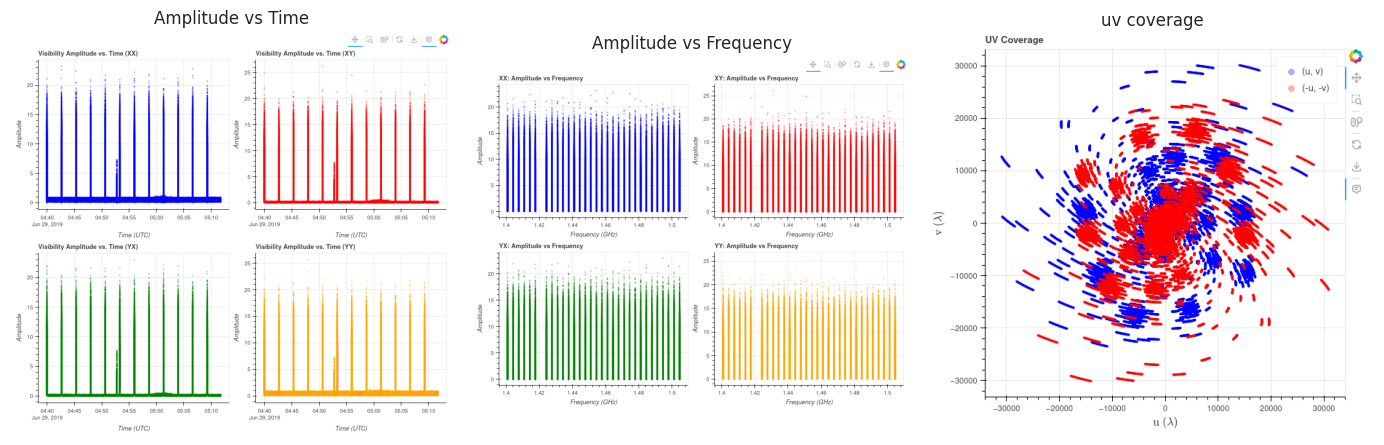

In [4]:
files = ['01-amp-vs-time.png', '02-amp-vs-freq.png', '03-uv-coverage.png']
labels = ['Amplitude vs Time', 'Amplitude vs Frequency', 'uv coverage']

# create a 1x2 grid of axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 18))

for ax, fname, lname in zip(axes, files, labels):
    img = mpimg.imread(fname)
    ax.imshow(img)
    ax.axis('off')          # hide axes ticks/labels
    ax.set_title(lname)     # optional: show filename as title

plt.tight_layout()
plt.show()

The time and frequency plots reveal pervasive, high‑amplitude RFI spikes across all channels throughout the observation.

### RFI detection and removal

To detect and remove these spikes, I implemented a detection algorithm based on a rolling median and its Median Absolute Deviation -- both robust estimators that are resistant to distortion by outliers. The routine can be run without modifying the MS to generate a CASA-compatible flag file or, optionally, replace the FLAG and FLAG_ROW columns in the MS.

For each baseline, the algorithm first forms the time-series of channel‑averaged amplitudes. Then, for each time it:

1. Takes a sliding window of neighboring times excluding itself.
2. Computes the median and the MAD of the amplitudes within that window.
3. Flags time if its amplitude lies more than multiplier*MAD away from the window’s median, where multiplier is chosen by the user.

The following plots (for two baselines) show which data points are marked as outliers by this algorithm for XX and YY correlations.

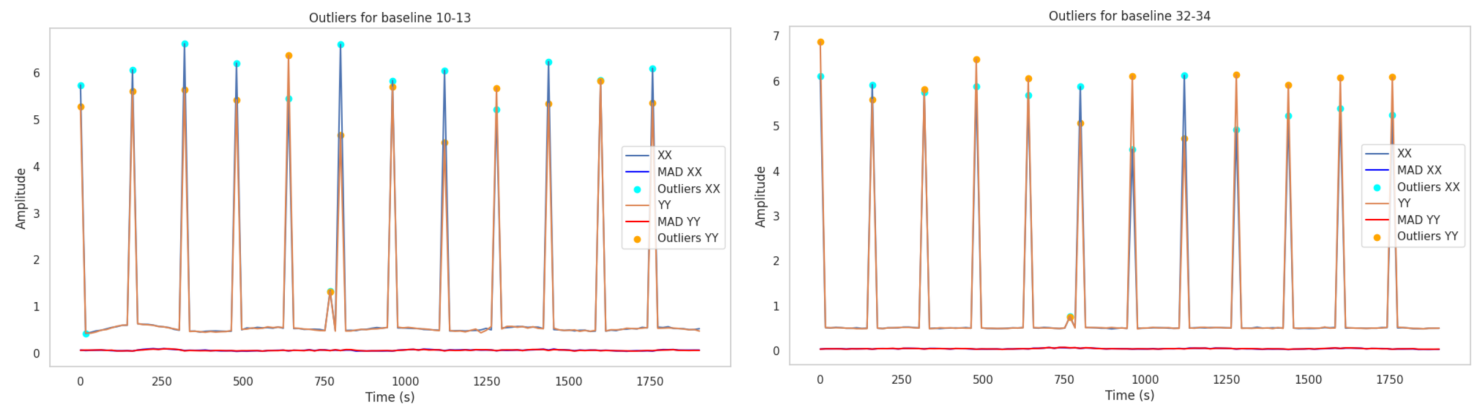

In [16]:
files = ['09-outliers-1013.png', '10-outliers-3234.png']

# create a 1x2 grid of axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 30))

for ax, fname in zip(axes, files):
    img = mpimg.imread(fname)
    ax.imshow(img)
    ax.axis('off')          # hide axes ticks/labels

plt.tight_layout()
plt.show()

Next, I ran the RFI detection algorithm in the submodule `dqatool.rfi` on the entire dataset. This method generates a flag file called `rfi-flags.txt` and optionally updates the flagging columns in the MS.

In [17]:
import importlib
importlib.reload(rfi)
rfi.detect_rfi_1d(ms_path=ms_path, overwriteflags=False) # do not overwrite FLAG columns for demo

Processing baselines: 100%|█████████████████████████████████████████████████████████| 1891/1891 [01:26<00:00, 21.91it/s]
2025-05-06 20:25:38,570 - INFO - dqatool.rfi - Flags not written to the MS. Use overwriteflags=True to write flags.
2025-05-06 20:25:38,808 - INFO - dqatool.rfi - RFI detection completed and flags written to rfi_flags.txt.


### Imaging

I processed the data, before and after flagging the RFI, with CASA’s `tclean` task using parameter values guided by the SARAO Sensitivity Calculator and produced the image below. On a typical laptop it required about 35 minutes to compute.

The imaging used the `dqatool.imtools` submodule, a thin wrapper around established packages that currently interfaces with CASA’s `tclean`. The images are displayed side-by-side for comparison.

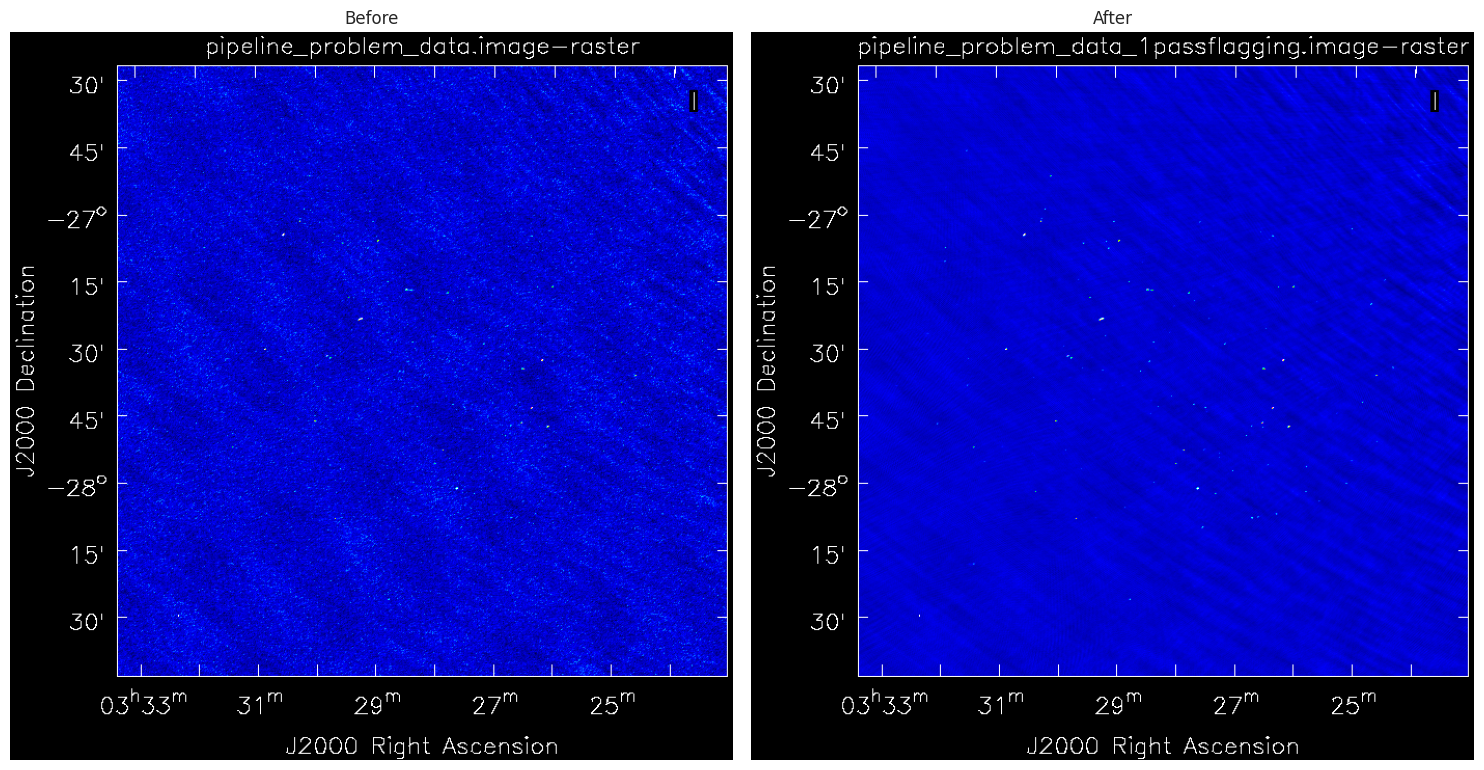

In [8]:
files = ['04-image-with-rfi.png', '05-image-with-rfi-flagged.png']
labels = ['Before', 'After']

# create a 1x2 grid of axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 30))

for ax, fname, lname in zip(axes, files, labels):
    img = mpimg.imread(fname)
    ax.imshow(img)
    ax.axis('off')          # hide axes ticks/labels
    ax.set_title(lname)     # optional: show filename as title

plt.tight_layout()
plt.show()

Subtracting the RFI‑flagged, imaged data from the model and examining the residuals provides a robust cross‑check on both the flagging and the modelling quality.

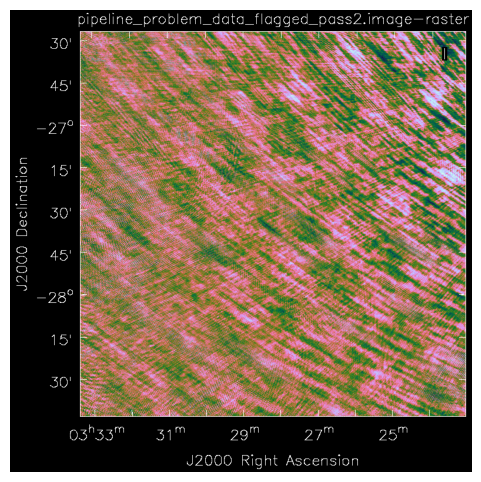

In [4]:
img = mpimg.imread('08-residuals.png')

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')    # hide axes
plt.show()